In [27]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy.integrate import simps
import pandas as pd
import control

In [28]:
chamber_step_110 = pd.read_csv("data_aquisition/temp_50_dt.csv")
chamber_step_80 = pd.read_csv("data_aquisition/temp_36_dt.csv")
chamber_step_220 = pd.read_csv("data_aquisition/temp_220V.csv")

chamber_step_110_off = pd.read_csv("data_aquisition/temp_50_dt_off.csv")
chamber_step_80_off = pd.read_csv("data_aquisition/temp_36_dt_off.csv")
chamber_step_220_off = pd.read_csv("data_aquisition/temp_220V_off.csv")


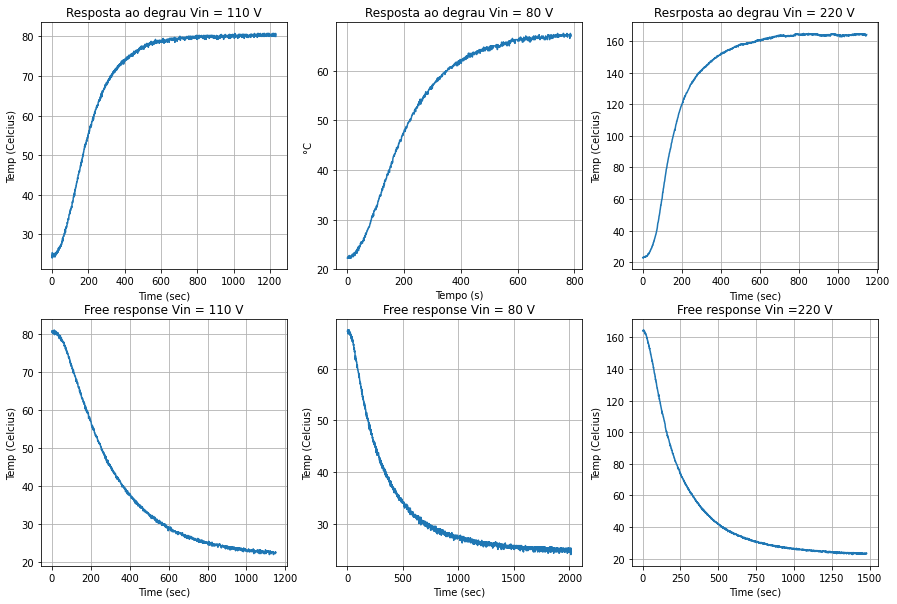

In [29]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Resposta ao degrau Vin = 110 V")
plt.plot(chamber_step_110.iloc[:, 0], chamber_step_110.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 2)
plt.title("Resposta ao degrau Vin = 80 V")
plt.plot(chamber_step_80.iloc[:, 0], chamber_step_80.iloc[:, 1])
plt.xlabel("Tempo (s)")
plt.ylabel("°C")
plt.grid()

plt.subplot(2, 3, 3)
plt.title("Resrposta ao degrau Vin = 220 V")
plt.plot(chamber_step_220.iloc[:, 0], chamber_step_220.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 4)
plt.title("Free response Vin = 110 V")
plt.plot(chamber_step_110_off.iloc[:, 0], chamber_step_110_off.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 5)
plt.title("Free response Vin = 80 V")
plt.plot(chamber_step_80_off.iloc[:, 0], chamber_step_80_off.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.subplot(2, 3, 6)
plt.title("Free response Vin =220 V")
plt.plot(chamber_step_220_off.iloc[:, 0], chamber_step_220_off.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

plt.show()



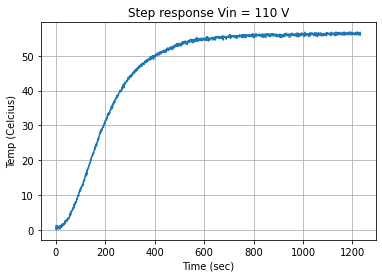

In [30]:
plt.title("Step response Vin = 110 V")
plt.plot(chamber_step_110.iloc[:, 0], np.subtract(chamber_step_110.iloc[:, 1], min(chamber_step_110.iloc[:, 1])))
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

## Identificando o tempo de atrado do sistema

Ao:  12799.416666666657
T + tau:  225.54038179148293
A1:  3421.1666666666665
tau:  163.87128074237538
T:  61.66910104910757


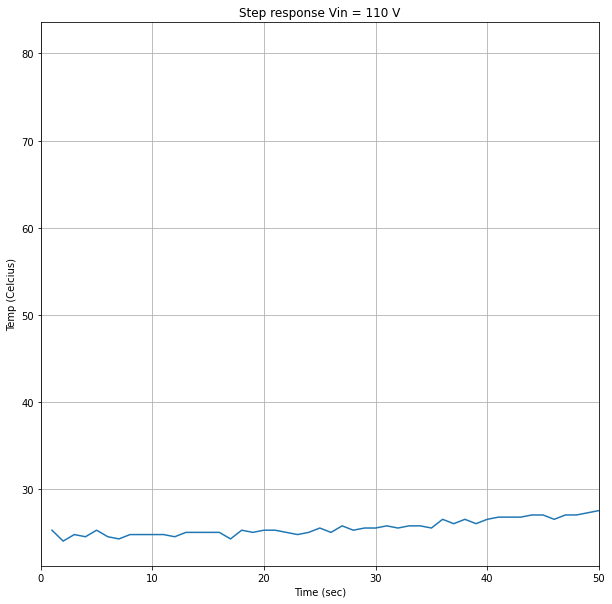

In [31]:
plt.figure(figsize=(10, 10))
plt.title("Step response Vin = 110 V")
plt.plot(chamber_step_110.iloc[:, 0], chamber_step_110.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.xlim(0, 50)
plt.grid()

# Cálulo das áreas para Vin = 110 V
y_t_110 = chamber_step_110.iloc[:, 1]
y_t_110 = np.subtract(y_t_110, min(y_t_110))
k = max(y_t_110)/110
a_zero = simps(np.subtract(k*110, y_t_110))

a_1_lim = a_zero/max(y_t_110)

fs = 1

x_array = np.arange(0, int(a_1_lim), fs)

a_1 = simps(y_t_110[:int(a_1_lim)])

print("Ao: ", a_zero)
print("T + tau: ", a_1_lim)
print("A1: ", a_1)

tau = a_1*np.exp(1)/max(y_t_110)
T = abs(a_zero - a_1*np.exp(1))/max(y_t_110)

print("tau: ", tau)
print("T: ", T)

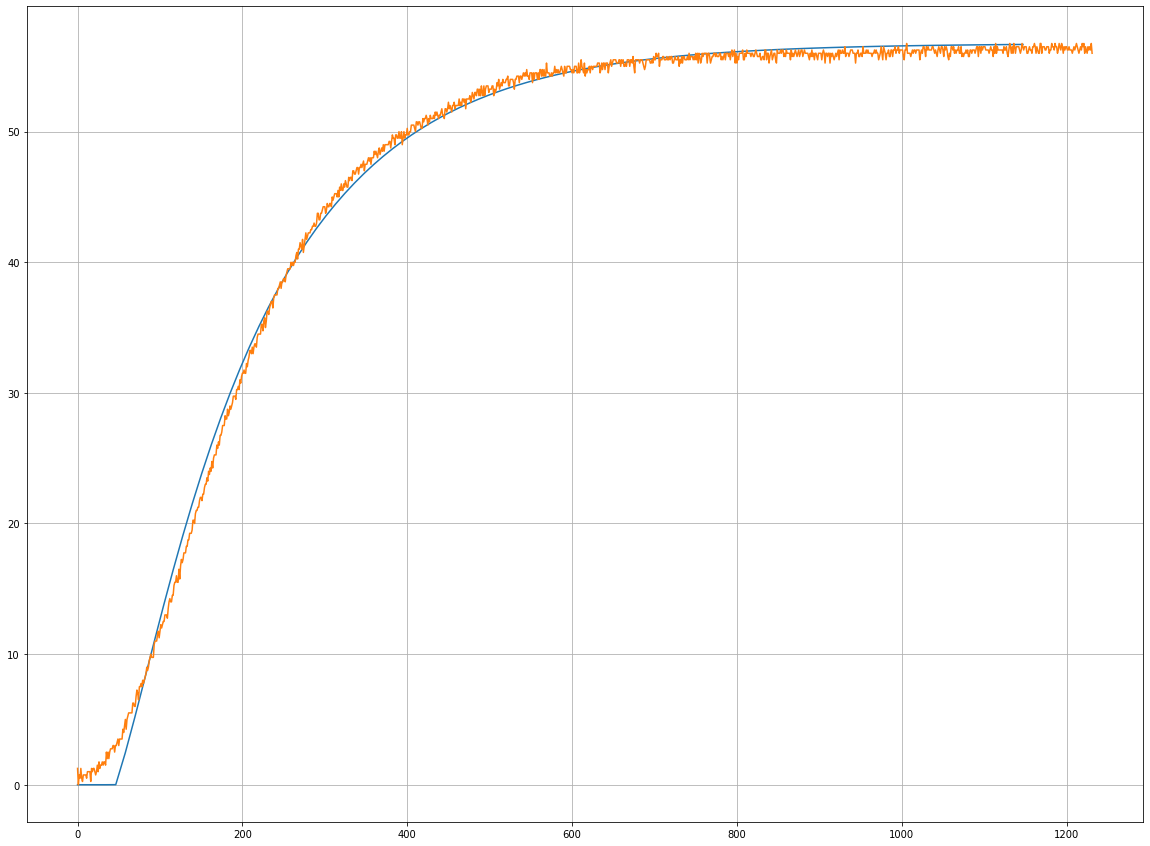

{'RiseTime': 366.29086075848267, 'SettlingTime': 693.5413162950581, 'SettlingMin': 0.46396772823621973, 'SettlingMax': 0.515220566718087, 'Overshoot': 0.0, 'Undershoot': -0.027378351039354633, 'Peak': 0.515220566718087, 'PeakTime': 1147.0989651966277, 'SteadyStateValue': 0.515220566718087}


In [32]:
num, den = control.pade(T, 1)

sys = control.TransferFunction(num, den)
sys_2 = control.TransferFunction([k], [tau, 1])

sys_comp = control.series(sys, sys_2)

t, y = control.step_response(sys_comp)

y = [i*110 if i > 0 else 0 for i in y]


plt.figure(figsize=(20, 15))
plt.plot(t, y)
plt.plot(y_t_110)
plt.grid()
plt.show()

print(control.step_info(sys_comp))

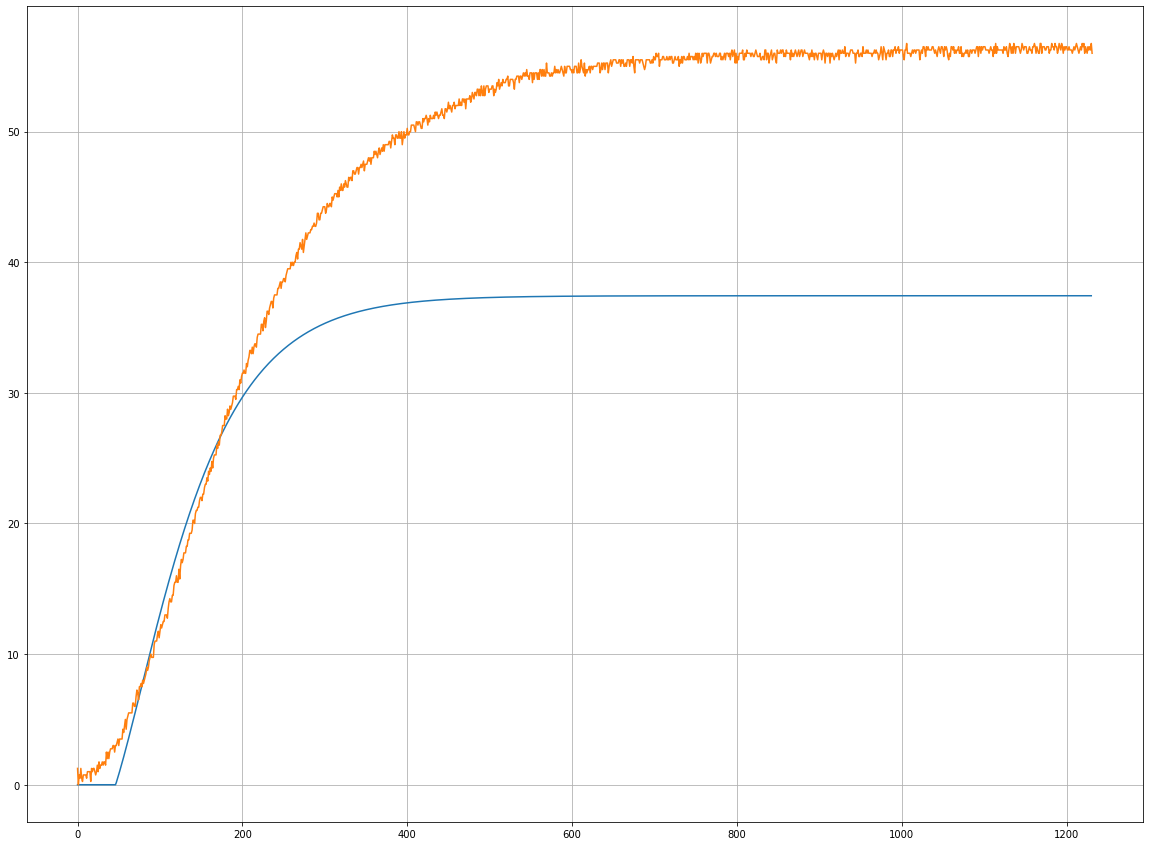

In [33]:
# Comportamento do sistema em malha fechada

sys_feed = control.feedback(sys1=sys_comp, sys2=1)

x = np.arange(0, len(y_t_110)-1)

t, y = control.step_response(sys_feed, x)

y = [i*110 if i > 0 else 0 for i in y]


plt.figure(figsize=(20, 15))
plt.plot(t, y)
plt.plot(y_t_110)
plt.grid()
plt.show()

## PID Design

### Ziegler-Nichols table rules for PID controllers

#### PI
* $K_p$ = $0.9*\frac{T}{L}$ 
* $T_i$ = $\frac{L}{0.3}$ 
* $T_d$ = 0

#### PID
* $K_p$ = $1.2*\frac{T}{L}$ 
* $T_i$ = $2*L$ 
* $T_d$ = $0.5*L$

In [34]:
# PID Tunning
Kp = 1.3 * tau/T
Ti = 3 * T
Td = 0.1 * T

P = control.TransferFunction(Kp, 1) 
I = control.TransferFunction(Kp, [Ti, 0])
D = control.TransferFunction([Kp*Td, 0], 1)

PID = P + I + D

#PI Tunning
Kp_pi =  .9*tau/T
Ti_pi = T/.3

P_pi = control.TransferFunction(Kp_pi, 1)
I_pi = control.TransferFunction(Kp_pi, [Ti_pi, 0])

PI = P_pi + I_pi

print(PID)
print(PI)


3941 s^2 + 639.1 s + 3.454
--------------------------
          185 s


491.6 s + 2.392
---------------
    205.6 s



0.5159090909090909


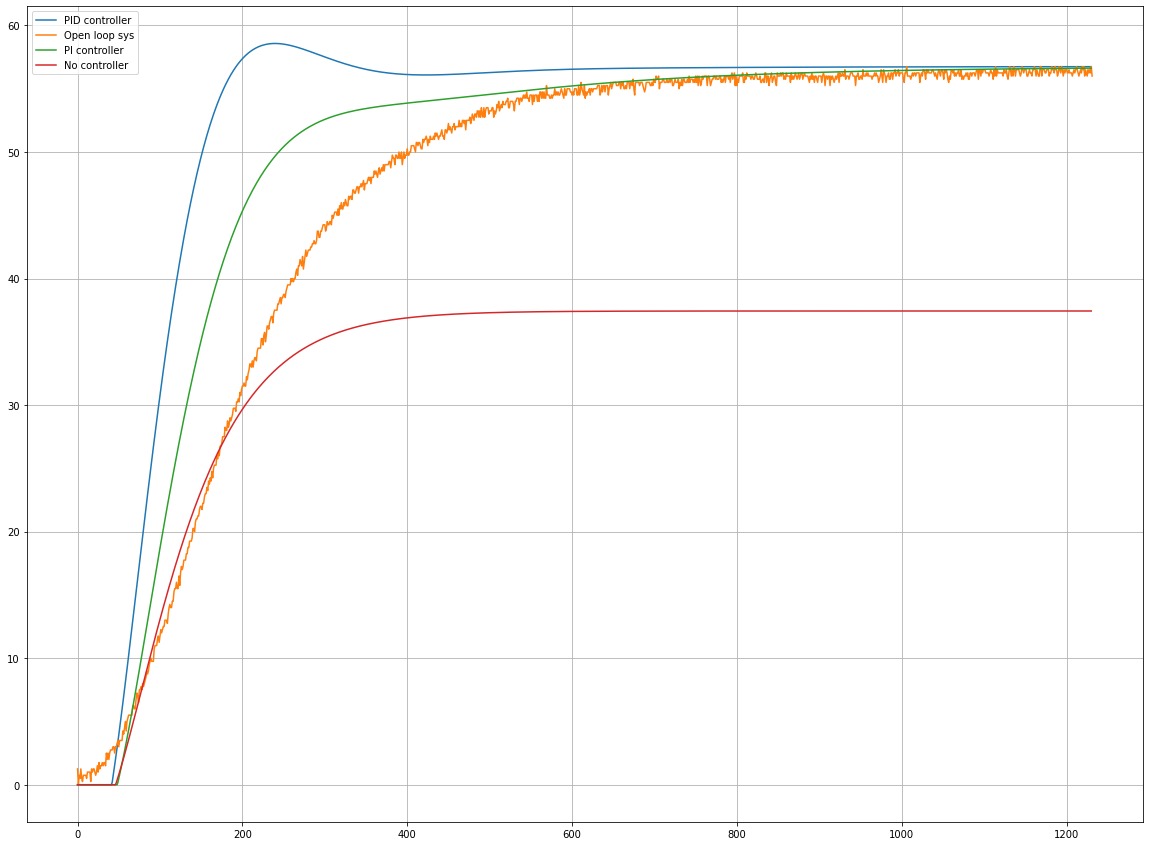

In [35]:
sys_PID = control.series(PID, sys_comp)
sys_fb = control.feedback(sys_PID, 1)

t, y = control.step_response(sys_fb, x)

y = [i*k*110 if i > 0 else 0 for i in y]


plt.figure(figsize=(20, 15))
plt.plot(t, y)
plt.plot(y_t_110)

print(k)

sys_PI = control.series(PI, sys_comp)
sys_fb_pi = control.feedback(sys_PI, 1)

t, y = control.step_response(sys_fb_pi, x)

y_pi = [i*k*110 if i > 0 else 0 for i in y]

plt.plot(t, y_pi)
plt.grid()

t, y = control.step_response(sys_feed, x)

y = [i*110 if i > 0 else 0 for i in y]

plt.plot(t, y)
plt.legend(['PID controller', 'Open loop sys', 'PI controller', 'No controller'])
plt.show()

In [36]:
print(Kp, Ti, Td)
print(Kp_pi, Ti_pi)

3.4544473867950254 185.00730314732272 6.166910104910757
2.3915404985504023 205.5636701636919


In [37]:
print(Kp_pi/Ti_pi)
print("Kp: ", Kp, "\nKi: ", Kp/Ti, "\nKd: ", Kp*Td)

0.011634062072573429
Kp:  3.4544473867950254 
Ki:  0.018671951474500566 
Kd:  21.3032664965088


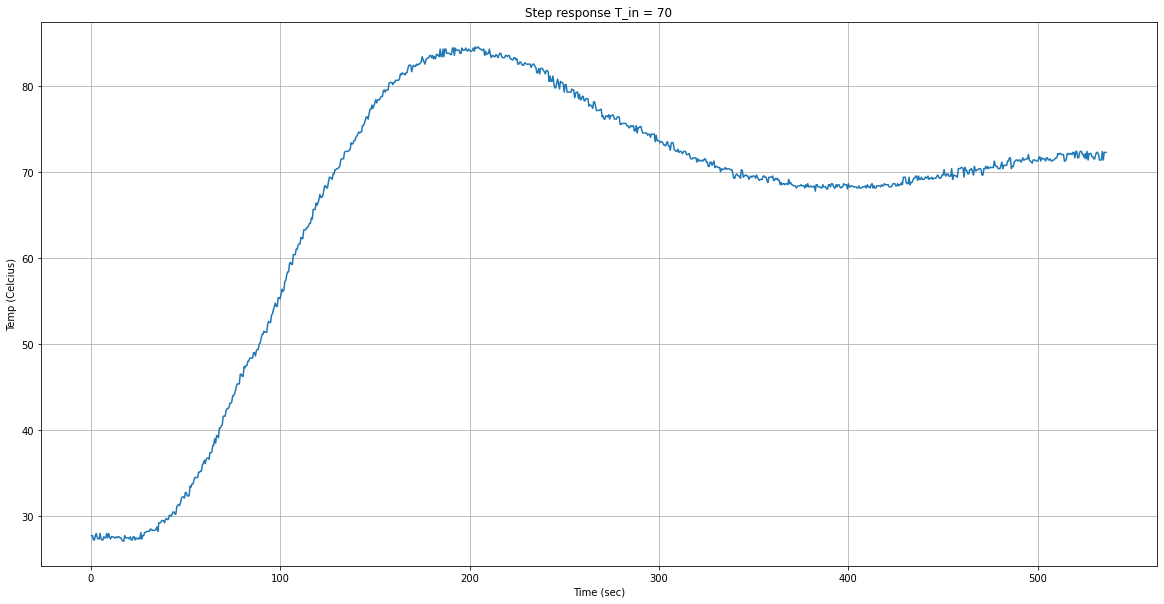

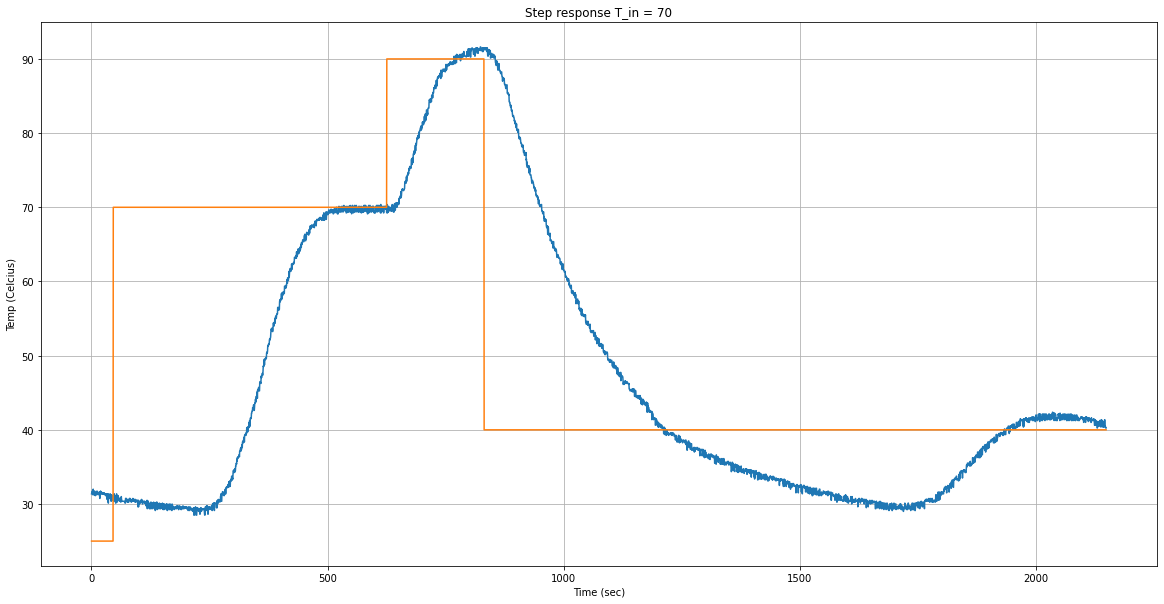

In [38]:
chamber_step_PID = pd.read_csv("data_aquisition/temp_control_pid.csv")

plt.figure(figsize=(20, 10))
plt.title("Step response T_in = 70")
plt.plot(chamber_step_PID.iloc[:, 0], chamber_step_PID.iloc[:, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

chamber_step_PI = pd.read_csv("data_aquisition/temp_control_pi.csv")

plt.figure(figsize=(20, 10))
plt.title("Step response T_in = 70")
plt.plot(chamber_step_PI.iloc[:, 0], chamber_step_PI.iloc[:, 1])
plt.plot(chamber_step_PI.iloc[:, 0], chamber_step_PI.iloc[:, 2])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

In [39]:
chamber_step_50dt = pd.read_csv("data_aquisition/temp_control_dt10.csv")
#chamber_step_50dt = pd.read_csv("data_aquisition/temp_220V.csv")


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

y_50dt = chamber_step_50dt.iloc[:, 1]
x_50dt = np.arange(0, len(y_50dt)*1, 1)

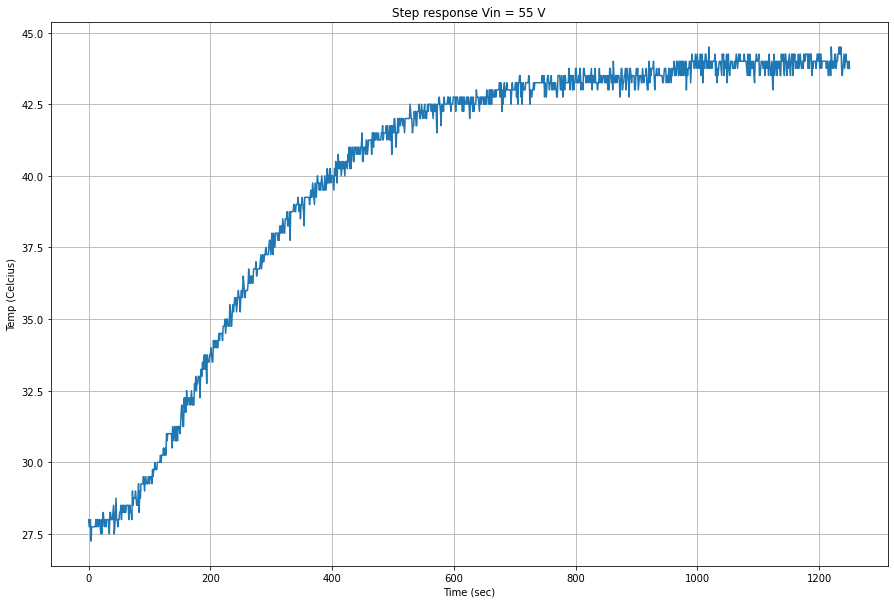

In [40]:
plt.figure(figsize=(15, 10))
plt.title("Step response Vin = 55 V")
plt.plot(x_50dt, y_50dt)
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

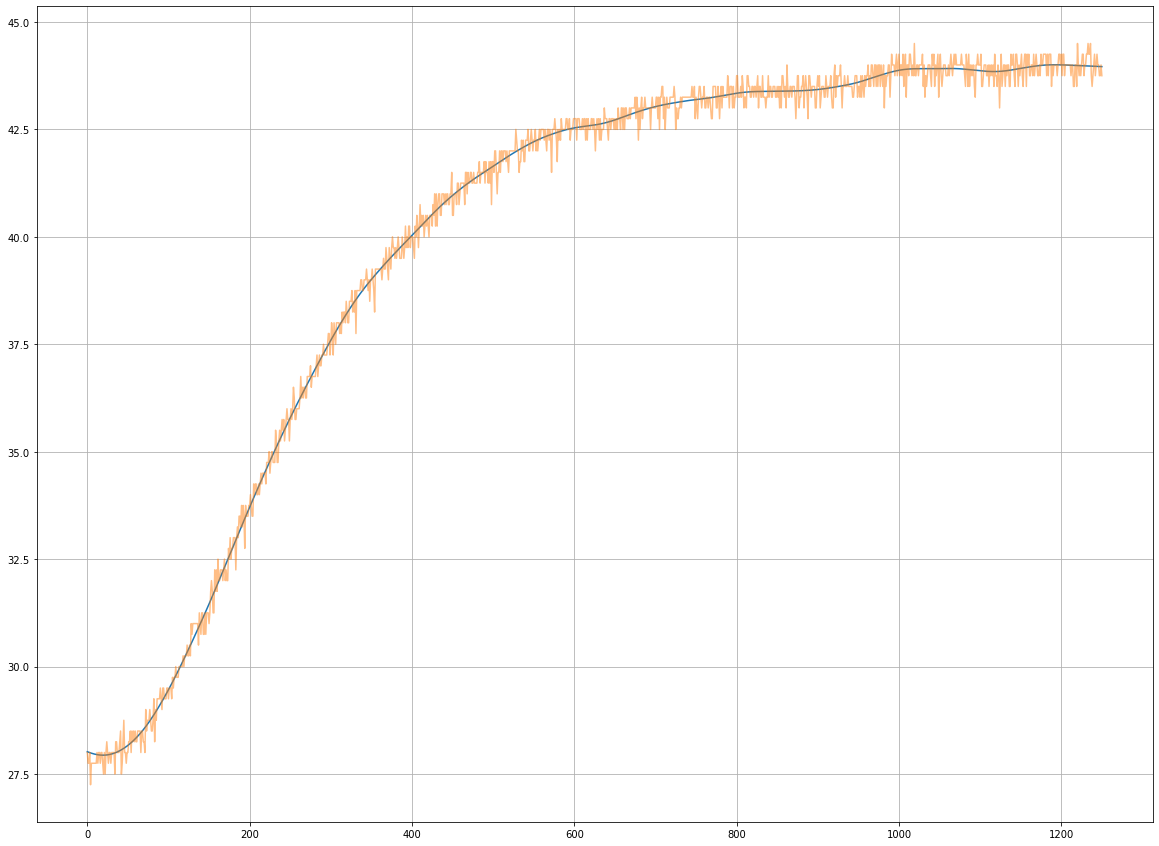

In [59]:
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.

T = x_50dt[-1]        # Sample Period
fs = 1      # sample rate, Hz
cutoff = .009     # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(y_50dt, cutoff, fs, order)
plt.figure(figsize=(20, 15))
plt.plot(x_50dt, y)
plt.plot(x_50dt,y_50dt, alpha=.5)
plt.grid()
plt.show()

In [60]:
max_y = max(y)

time = 0
for i in y:
    if i >= 0.98*max_y:
        tr_2 = time
        break
    time += 1
    
time = 0
        
for i in y:
    if i >= 0.95*max_y:
        tr_5 = time
        break
    time += 1
        
print(tr_2, tr_5, 65536/4, max(y)-min(y))

725 513 16384.0 16.06625562044067


In [61]:
def get_curve_params(y_data, fs, v_in):
    y = np.subtract(y_data, min(y_data))

    k = max(y)/v_in
    
    a_zero = simps(np.subtract(k*v_in, y), dx= 1/fs)
    print(a_zero/max(y))

    a_1_lim = a_zero/max(y)

    a_1 = simps(y[:int(a_1_lim)], dx=1/fs)
    print(a_1)

    tau = a_1*np.exp(1)/max(y) # T
    T = abs(a_zero - a_1*np.exp(1))/max(y) # alpha
    
    return T, tau, k, y

309.0251104421853
1257.402272467809
96.28271239619893 212.74239804598633 0.29211373855346673 16.06625562044067 1251

-s^3 + 0.1246 s^2 - 0.006472 s + 0.0001344
------------------------------------------
s^3 + 0.1246 s^2 + 0.006472 s + 0.0001344
 
  0.2921
-----------
212.7 s + 1
 
    -0.2921 s^3 + 0.03641 s^2 - 0.001891 s + 3.927e-05
---------------------------------------------------------
212.7 s^4 + 27.51 s^3 + 1.502 s^2 + 0.03507 s + 0.0001344



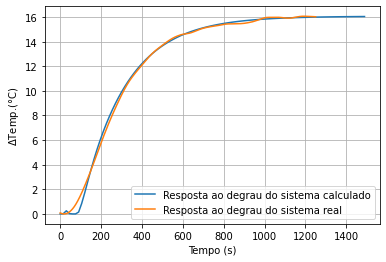

In [73]:

T, tau, k, new_y = get_curve_params(y, 1, 55)
print(T, tau, k, max(new_y), len(y))

num, den = control.pade(T, 3)


sys = control.TransferFunction(num, den)

sys_2 = control.TransferFunction([k], [tau, 1])

sys_comp = control.series(sys, sys_2)

print(sys, sys_2, sys_comp)

t, y_mat = control.step_response(sys_comp)

y_mat = [i*55 if i > 0 else 0 for i in y_mat]


plt.figure()
plt.plot(t,y_mat)
plt.plot(x_50dt, new_y)
plt.xlabel("Tempo (s)", size=10)
plt.ylabel("$\Delta$Temp.(°C)")
plt.legend(["Resposta ao degrau do sistema calculado", "Resposta ao degrau do sistema real"])
plt.grid()
plt.savefig("signal_comp.pdf", bbox_inches='tight')
plt.show()

In [45]:
x_data = x_50dt

def tune_ZN_PID(T, tau):
   # PID Tunning
    Kp = 1 * tau/T
    Ti = 2 * T
    Td = 0.3 * T
    
    return Kp, Ti, Td

def tune_ZN_PI(T, tau):
    Kp =  .9*tau/T
    Ti = T/.3
    return Kp, Ti

Kp, Ti, Td = tune_ZN_PID(T, tau)
Kp_pi, Ti_pi = tune_ZN_PI(T, tau)

# Create PID controlled system
P = control.TransferFunction(Kp, 1) 
I = control.TransferFunction(Kp, [Ti, 0])
D = control.TransferFunction([Kp*Td, 0], 1)

PID = P + I + D

sys_PID = control.series(PID, sys_comp)
sys_fb_pid = control.feedback(sys_PID, 1)


# Create PI controlled system
P_pi = control.TransferFunction(Kp_pi, 1)
I_pi = control.TransferFunction(Kp_pi, [Ti_pi, 0])

PI = control.parallel(P_pi, I_pi)

sys_PI = control.series(PI, sys_comp)
sys_fb_pi = control.feedback(sys_PI, 1)


print("PID:\n\t Kp: ", Kp, "\tKi: ", Kp/Ti, "\tKd: ", Kp*Td)
print("PI:\n\tKp: ", Kp_pi, "\tKi: ", Kp_pi/Ti_pi)

PID:
	 Kp:  2.209559668100761 	Ki:  0.011474332271657058 	Kd:  63.8227194137959
PI:
	Kp:  1.9886037012906848 	Ki:  0.00619613942669481


In [46]:
def compare_systems(y_inf, K, x_data, original, PI=None, PID=None):
    plt.figure(figsize=(20, 15))
    legend = []
    
    # Compute step response
    if PI is not None:
        t_pi, y_pi = control.step_response(PI, x_data)
        y_pi = [i*y_inf if i > 0 else 0 for i in y_pi]
        plt.plot(t_pi, y_pi)
        legend.append("PI Response")
        
    if PID is not None:
        t_pid, y_pid = control.step_response(PID, x_data)
        y_pid = [i*y_inf if i > 0 else 0 for i in y_pid]
        plt.plot(t_pid, y_pid)
        legend.append("PID Response")

    t, y = control.step_response(original, x_data)
    y = [i*y_inf/k if i > 0 else 0 for i in y]

    plt.plot(x_data, y)
    plt.grid()
    
    #legend.append("Normal Response")

    #plt.legend(legend)
    plt.show()


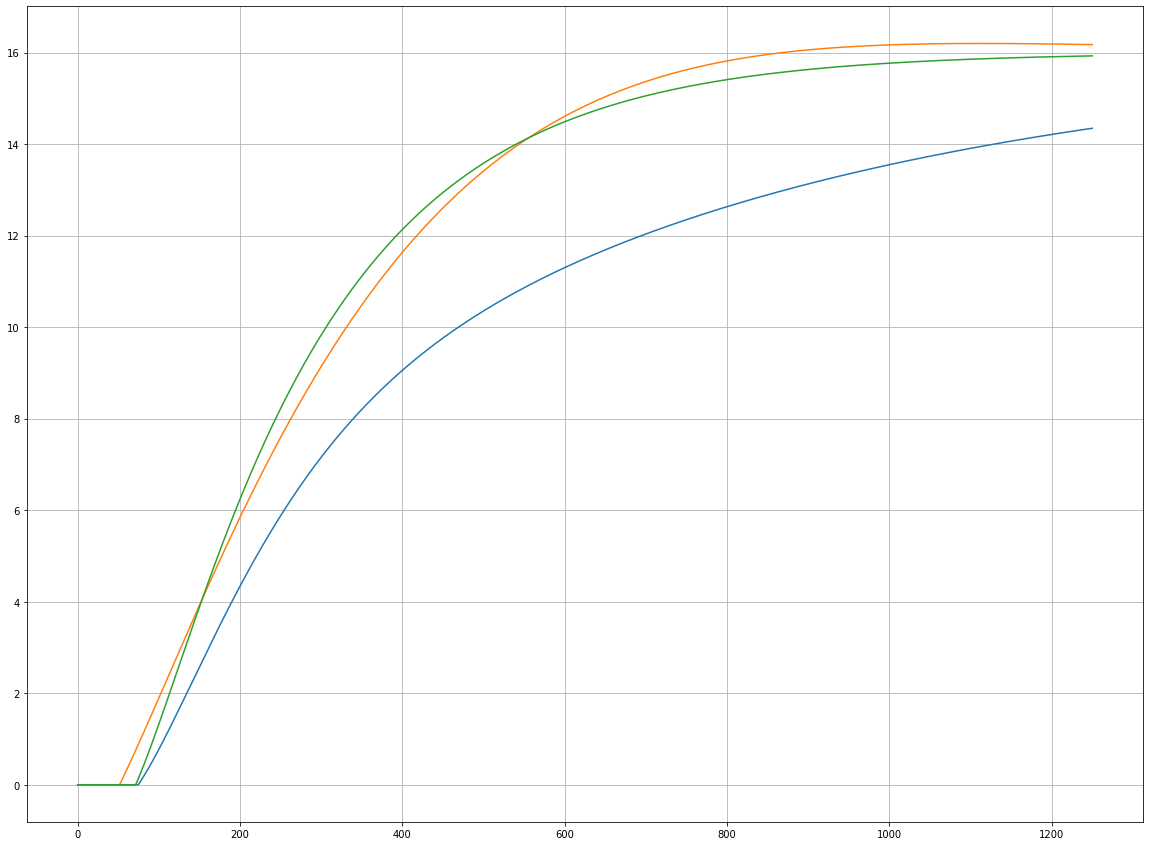

In [47]:
compare_systems(16, k, x_data, sys_comp, sys_fb_pi, sys_fb_pid)

In [48]:
print(T)

96.28271239619893


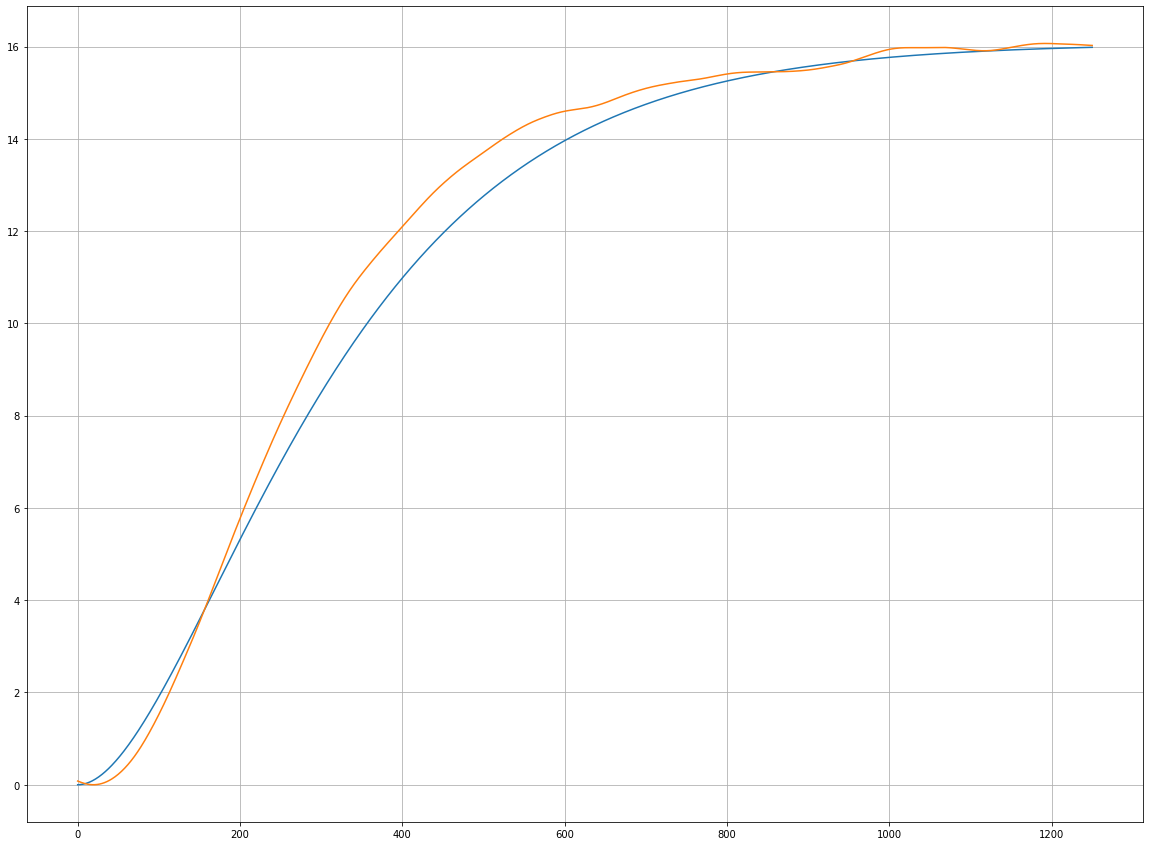

In [49]:
den_novo = [1, 2*0.00591, 0.00591**2]
num_novo = [k*0.00591**2]

tf_novo = control.TransferFunction(num_novo, den_novo)

t_teste, y_teste = control.step_response(tf_novo, x_data)
y_teste = [i*55 if i > 0 else 0 for i in y_teste]

plt.figure(figsize=(20, 15))
plt.plot(x_data, y_teste)
plt.plot(x_data, np.subtract(y, min(y)))
plt.grid()

plt.show()

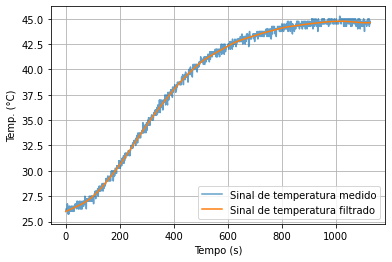

In [50]:
f = plt.figure()

plt.plot(x_dt,y_dt, alpha=.7)
plt.plot(x_dt, y_dt_filter)
plt.ylabel("Temp. (°C)")
plt.xlabel("Tempo (s)")
plt.legend(['Sinal de temperatura medido', 'Sinal de temperatura filtrado'])
plt.grid()
plt.show()

f.savefig("signal_step_control.pdf", bbox_inches='tight')

In [51]:
chamber_step_control = pd.read_csv("data_aquisition/pi_control_44.csv")
y_dt = chamber_step_control.iloc[:, 1]
x_dt = np.arange(0, len(y_dt)*1, 1)

y_dt_filter= butter_lowpass_filter(y_dt, cutoff, fs, order)

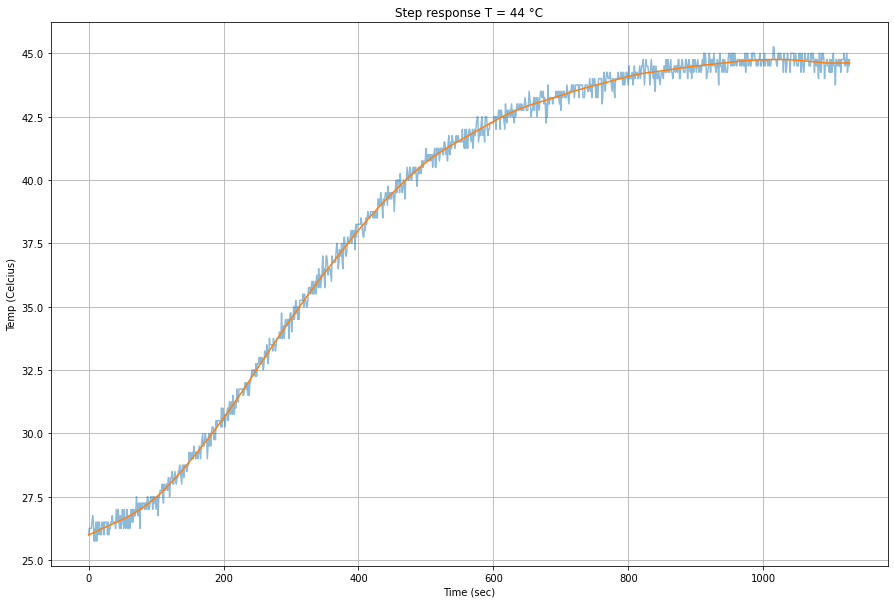

In [52]:
plt.figure(figsize=(15, 10))
plt.title("Step response T = 44 °C")
plt.plot(x_dt, y_dt, alpha=.5)
plt.plot(x_dt, y_dt_filter)
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()

In [53]:
#t_pi, y_pi = control.step_response(sys_fb_pi, x_dt)
target = 44
t, y, x_out = control.forced_response(sys_fb_pi, x_dt, [44 for i in x_dt], 25)
y_pi_2 = [i*19 + 26 if i > 0 else 26 for i in y]
#plt.plot(t_pi, y_pi)



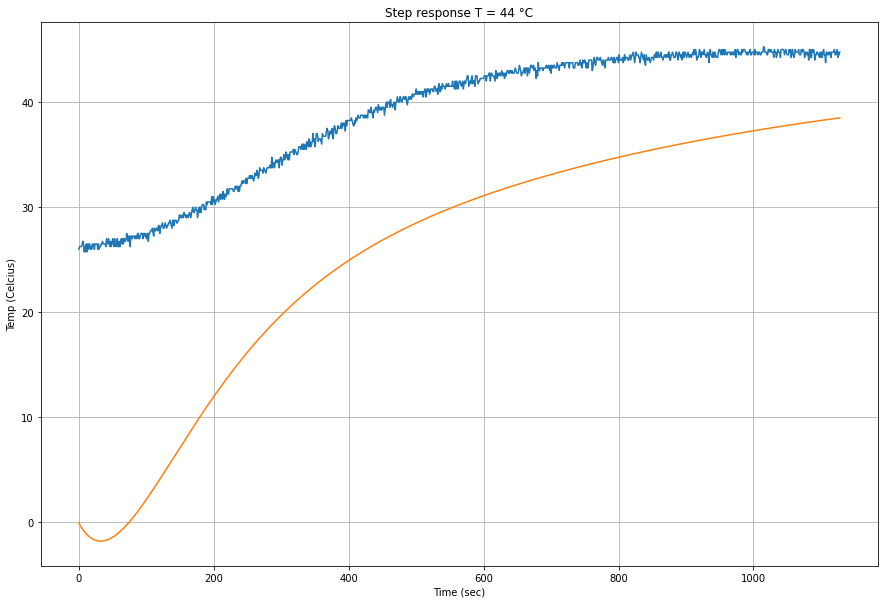

In [54]:
plt.figure(figsize=(15, 10))
plt.title("Step response T = 44 °C")
plt.plot(x_dt, y_dt)
plt.plot(x_dt, y)
plt.xlabel("Time (sec)")
plt.ylabel("Temp (Celcius)")
plt.grid()